### Import libraries

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from d2l import torch as d2l

### Load the data 

In [2]:
# Load the MovieLens ratings dataset
ratings_df = pd.read_csv("C:/Users/bbste/Documents/Summer '23/data/ratings.csv")

### Create our new DataFrame
* We will fill in missing ratings so that all users have the same length tensors

In [3]:
# Create an empty DataFrame with columns representing movies
df = pd.DataFrame(columns=ratings_df['movieId'].unique())

# Sort the columns in ascending order
df = df.sort_index(axis=1)

In [4]:
# Iterate over the ratings data to fill the DataFrame
for _, row in ratings_df.iterrows():
    user_id = row['userId']
    movie_id = row['movieId']
    rating = row['rating']
    if user_id not in df.index:
        df.loc[user_id] = 0 #np.nan
    df.loc[user_id, movie_id] = rating

In [5]:
# Fill missing values with zeros
#movies_df = movies_df.fillna(0)

In [6]:
# View the sparse DataFrame
df.head()

,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
1.0,4.0,0,4.0,0,0,4.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5.0,4.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Convert to a tensor

In [7]:
# Change columns to numeric
df = df.apply(pd.to_numeric)

In [8]:
# Convert the DataFrame to a NumPy array
df_array = df.values

# Convert the NumPy array to a PyTorch tensor
df_tensor = torch.tensor(df_array, dtype=torch.float32)

# Print the tensor shape
print(df_tensor.shape)

torch.Size([610, 9724])


In [9]:
df_tensor

tensor([[4.0000, 0.0000, 4.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [2.5000, 2.0000, 2.0000,  ..., 0.0000, 0.0000, 0.0000],
        [3.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [5.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

### Mask the missing values

In [10]:
# Create a mask
mask_tensor = (df_tensor == 0)  

# Apply the mask to the tensor
masked_tensor = df_tensor.clone()
masked_tensor[mask_tensor] = torch.tensor(0)

# Print the masked tensor
print(masked_tensor)

tensor([[4.0000, 0.0000, 4.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [2.5000, 2.0000, 2.0000,  ..., 0.0000, 0.0000, 0.0000],
        [3.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [5.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


In [11]:
len(masked_tensor[0])

9724

In [12]:
data = [(masked_tensor[i].clone().detach().requires_grad_(True), torch.tensor(0)) for i in range(len(df))]

In [13]:
len(data)

610

### Create our DataLoader 

In [14]:
# Split our data into train and test sets with an 80:20 split
train_size = int(0.8 * len(data))
test_size = len(data) - train_size

train_dataset, test_dataset = torch.utils.data.random_split(data, [train_size, test_size])

In [15]:
# Create the train and test loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [16]:
# Modify the train and test loaders to return (input, None) tuples
#train_loader = [(input, None) for input in train_loader]
#test_loader = [(input, None) for input in test_loader]

In [17]:
#train_loader = train_loader[:20]
#test_loader = test_loader[:10]

### Build the autoencoder

<div>
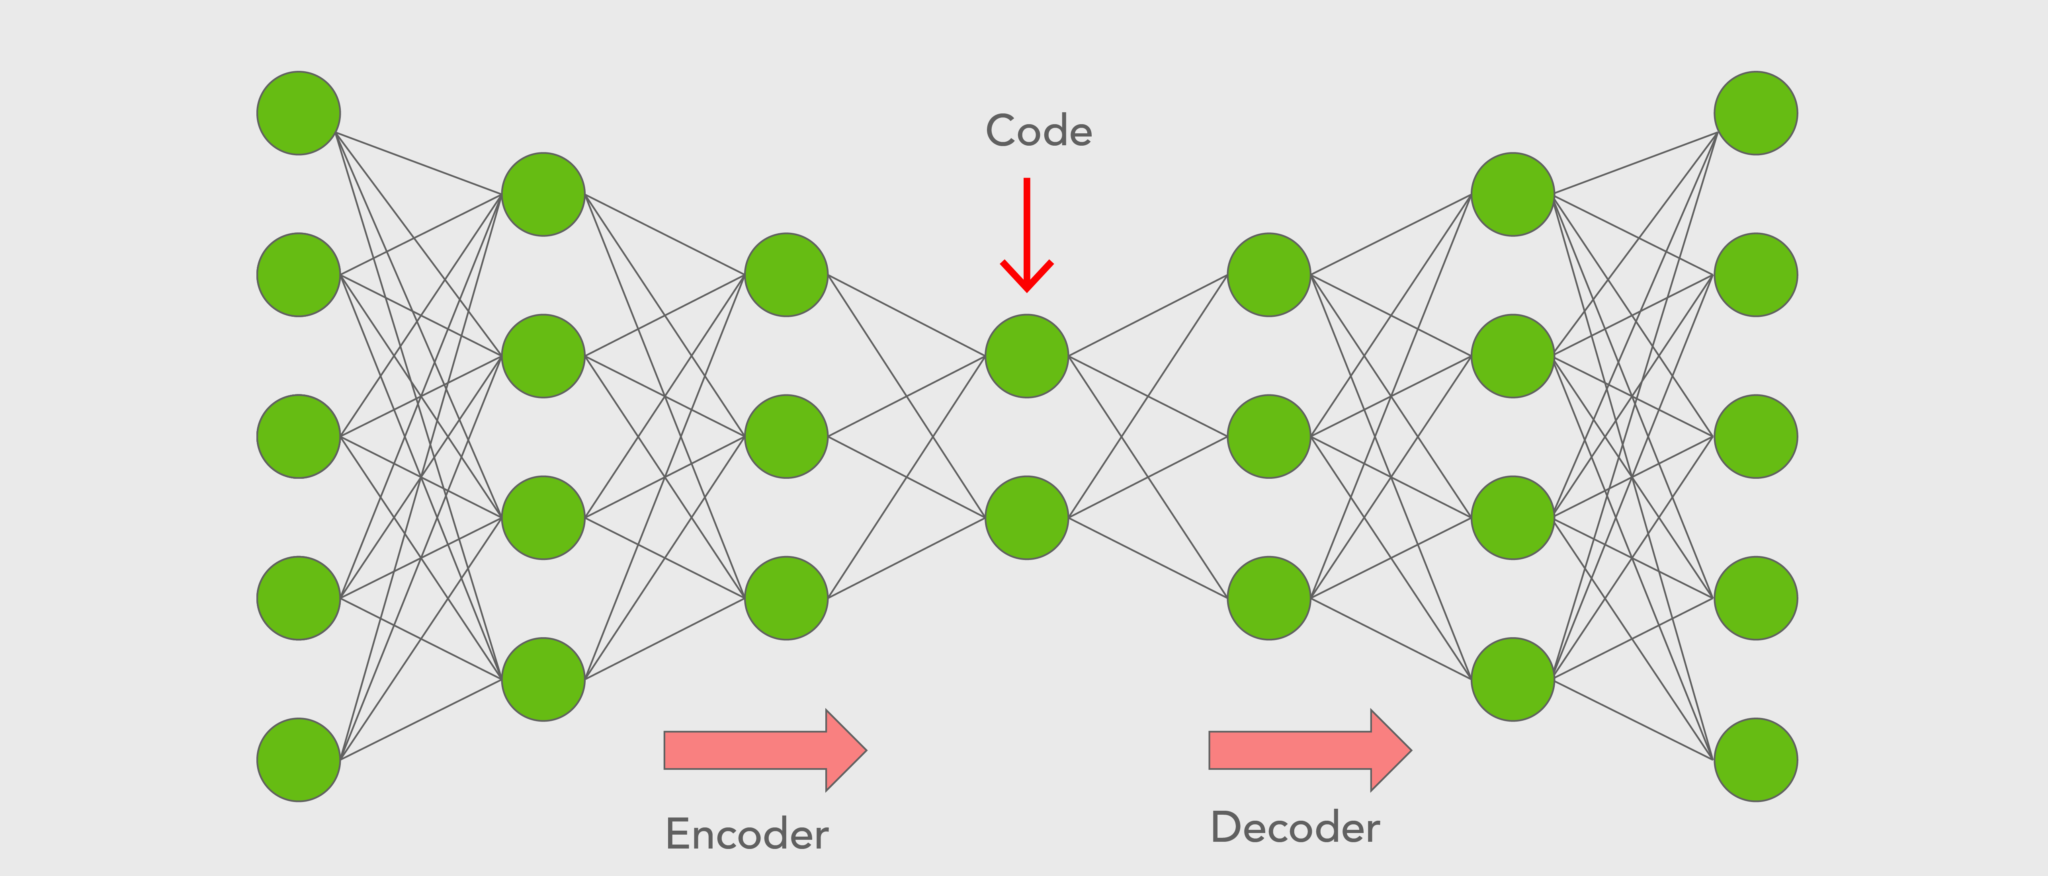
</div>

In [18]:
# Specify the input size
input_dim = len(df.columns)

In [19]:
# Build our model
autoencoder = nn.Sequential(
    nn.Linear(input_dim, 1024),
    nn.Sigmoid(),
    nn.Linear(1024, 256), #nn.Dropout(0.5),
    nn.Sigmoid(),
    nn.Linear(256, 64),
    nn.Sigmoid(),
    nn.Linear(64, 256),
    nn.Sigmoid(),
    nn.Linear(256, 1024), #nn.Dropout(0.5),
    nn.Sigmoid(),
    nn.Linear(1024, input_dim),
    nn.Sigmoid(),
)

In [20]:
#Define our loss function
loss = nn.MSELoss()

#Define our optimisation algorithm
trainer = torch.optim.SGD(autoencoder.parameters(), lr=1)

#Define our number of epochs
num_epochs = 50

In [21]:
# Train the autoencoder
for epoch in range(num_epochs):
    train_loss = 0.0  # Variable to store the train loss

    # Training loop
    autoencoder.train()  # Set the model to training mode
    for input, _ in train_loader:
        input = input.clone().detach().requires_grad_(True)
        # Forward pass
        reconstructed = autoencoder(input)

        # Compute the loss (e.g., MSE loss)
        loss = nn.MSELoss()(reconstructed, input)

        # Backward pass and optimization
        trainer.zero_grad()
        loss.backward()
        trainer.step()

        # Accumulate the train loss
        train_loss += loss.item()

    # Compute the average train loss
    avg_train_loss = train_loss / len(train_loader)

    # Print the average train loss for the epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    # Test loop
    autoencoder.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        test_loss = 0.0  # Variable to store the test loss
        for input, _ in test_loader:
            # Forward pass
            reconstructed = autoencoder(input)

            # Compute the loss (e.g., MSE loss)
            loss = nn.MSELoss()(reconstructed, input)

            # Accumulate the test loss
            test_loss += loss.item()

        # Compute the average test loss
        avg_test_loss = test_loss / len(test_loader)

        # Print the average test loss for the epoch
        print(f"Epoch [{epoch+1}/{num_epochs}], Test Loss: {avg_test_loss:.4f}")

Epoch [1/50], Train Loss: 0.3577
Epoch [1/50], Test Loss: 0.2815
Epoch [2/50], Train Loss: 0.2708
Epoch [2/50], Test Loss: 0.2254
Epoch [3/50], Train Loss: 0.2363
Epoch [3/50], Test Loss: 0.2049
Epoch [4/50], Train Loss: 0.2236
Epoch [4/50], Test Loss: 0.1966
Epoch [5/50], Train Loss: 0.2182
Epoch [5/50], Test Loss: 0.1926
Epoch [6/50], Train Loss: 0.2154
Epoch [6/50], Test Loss: 0.1904
Epoch [7/50], Train Loss: 0.2138
Epoch [7/50], Test Loss: 0.1891
Epoch [8/50], Train Loss: 0.2128
Epoch [8/50], Test Loss: 0.1882
Epoch [9/50], Train Loss: 0.2121
Epoch [9/50], Test Loss: 0.1876
Epoch [10/50], Train Loss: 0.2117
Epoch [10/50], Test Loss: 0.1871
Epoch [11/50], Train Loss: 0.2113
Epoch [11/50], Test Loss: 0.1868
Epoch [12/50], Train Loss: 0.2110
Epoch [12/50], Test Loss: 0.1865
Epoch [13/50], Train Loss: 0.2108
Epoch [13/50], Test Loss: 0.1863
Epoch [14/50], Train Loss: 0.2106
Epoch [14/50], Test Loss: 0.1861
Epoch [15/50], Train Loss: 0.2105
Epoch [15/50], Test Loss: 0.1860
Epoch [16/50]

KeyboardInterrupt: 

In [23]:
# Set the model to evaluation mode
autoencoder.eval()

# Select a specific input for observation
input_index = 500
input_data, _ = train_dataset[input_index]

# Forward pass to obtain the reconstructed output
reconstructed_output = autoencoder(input_data.unsqueeze(0))  # Add batch dimension

# Print the input and reconstructed output
print("Input:", input_data)
print("Reconstructed Output:", reconstructed_output.squeeze(0))  # Remove the batch dimension

IndexError: list index out of range